# A/B Testing on E-commerce

*(Personal Projects for Learning Purpose)*

## Project Intro

**Background**

An e-commerce would like to launch a new version of menu page from the website, so the Product Manager asked to do an experiment with the hope that the new version of menu page will lead to a higher conversion rate. Let's assume that the conversion rate in this e-commerce was 12%, and the Product Manager would like to increase conversion rate to 15%.



**Dataset**

The dataset was taken from <a href= "https://www.kaggle.com/datasets/zhangluyuan/ab-testing">Kaggle</a> and consists of `user ID`, `timestamp`, `control/treatment group`, `type of landing page`, and whether the user `converted` or not.

**Project Purpose**

The purpose was to help the Product Manager in deciding which menu page is giving better conversion rate.

## Data Preparation

### Import Library and Dataset

In [45]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import math

In [2]:
# import file csv 
ori_data = pd.read_csv(r'E:\Learn Data\Projects\ab_ecommerce.csv')

### Cleaning Data

In [3]:
# checking dataframe
ori_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# checking data type
ori_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [5]:
df_type = ori_data.copy()

Change `timestamp` column data type from `object` into `datetime64`.

In [6]:
# changing data type
df_type['timestamp']= pd.to_datetime(df_type['timestamp'])

In [30]:
# checking data type again
df_type.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [9]:
# checking data shape
df_type.shape

(294478, 5)

In [10]:
df_dup = df_type.copy()

In [11]:
# checking duplicated data
df_dup[df_dup.duplicated()]

,user_id,timestamp,group,landing_page,converted


In [12]:
df_dup.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

There are users who see more than one menu page in different time. Therefore, we need to remove them.

In [13]:
df_dup[df_dup['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2656,698120,2017-01-15 17:13:42.602796,control,old_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0
7500,899953,2017-01-07 03:06:54.068237,control,new_page,0
8036,790934,2017-01-19 08:32:20.329057,treatment,new_page,0
10218,633793,2017-01-17 00:16:00.746561,treatment,old_page,0
...,...,...,...,...,...
294308,905197,2017-01-03 06:56:47.488231,treatment,new_page,0
294309,787083,2017-01-17 00:15:20.950723,control,old_page,0
294328,641570,2017-01-09 21:59:27.695711,control,old_page,0
294331,689637,2017-01-13 11:34:28.339532,control,new_page,0


In [14]:
# drop all rows with duplicate user_id
df_dup = df_dup.drop_duplicates(subset='user_id',keep=False)

In [15]:
# checking the shape again
df_dup.shape

(286690, 5)

In [16]:
print('Before removing duplicates, there are {} rows data.' .format(len(ori_data)))
print('After removing duplicates, there are {} rows data. Only {}% of total data were removed.' .format(len(df_dup),100*(1-(len(df_dup)/len(ori_data)))))

Before removing duplicates, there are 294478 rows data.
After removing duplicates, there are 286690 rows data. Only 2.6446797383845366% of total data were removed.


In [17]:
# checking missing value
df_dup.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing value detected.

In [18]:
df_ok = df_dup.copy()

We need to make sure that users from control group are looking only at the old design, and users from treatment group are looking only at the new design.

In [19]:
# create frequency table 
pd.crosstab(df_ok['group'],df_ok['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


## Data Exploration

In [27]:
df_ok.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [26]:
# checking start and end date of dataset
print("The experiment was conducted between", df_ok['timestamp'].min(),'and',df_ok['timestamp'].max())

The experiment was conduct between 2017-01-02 13:42:05.378582 and 2017-01-24 13:41:54.460509


In [28]:
df_test = pd.DataFrame({'N_Control': df_ok[df_ok['group']=='control'].converted.value_counts(),
                       'N_Treatment': df_ok[df_ok['group']=='treatment'].converted.value_counts(),
                       'ratio_Control': df_ok[df_ok['group']=='control'].converted.value_counts()/len(df_ok[df_ok['group']=='control']),
                       'ratio_Treatment': df_ok[df_ok['group']=='treatment'].converted.value_counts()/len(df_ok[df_ok['group']=='treatment'])})
df_test

,N_Control,N_Treatment,ratio_Control,ratio_Treatment
0,126073,126372,0.879827,0.881274
1,17220,17025,0.120173,0.118726


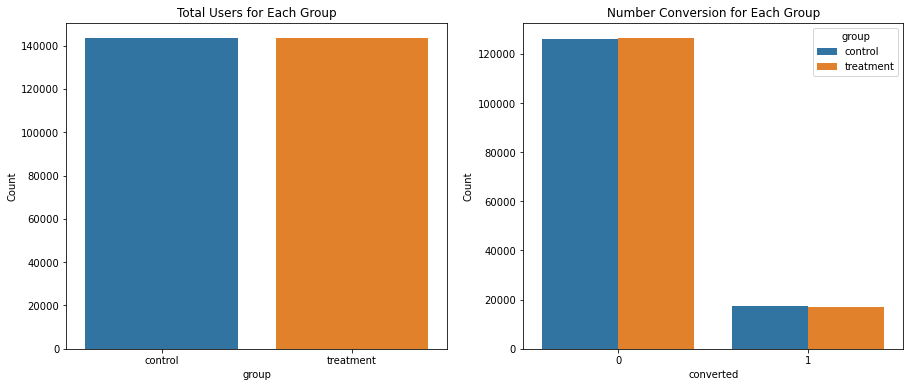

In [29]:
fig, axes = plt.subplots(1,2)

sns.countplot(x='group', data=df_ok, ax=axes[0])
axes[0].set(title="Total Users for Each Group", ylabel='Count')

sns.countplot(x='converted', data=df_ok, ax=axes[1], hue='group')
axes[1].set(title='Number Conversion for Each Group', ylabel='Count')
fig.set_size_inches(15, 6)

Based on the graph above, total users for each group in this experiment are balanced enough.

In [74]:
conversion_rates = df_ok.groupby('group')['converted'].agg([np.mean, np.std])
conversion_rates.columns = ['conversion_rate', 'std_deviation']
conversion_rates

,conversion_rate,std_deviation
group,,
control,0.120173,0.325165
treatment,0.118726,0.323467


The control group shows us **12.01%** of conversion rate, slightyly better than the treatment group that shows us **11.87%** of conversion rate. But, A/B Testing will be performed for more accurate analysis.

## A/B Testing I

*(All Data)*

In this project, we will be performing two-tailed hypothesis testing with confidence interval of 95% ***(alpha treshold = 0.05)***.

**The hypothesis will be formulated as follow :**

H0 : Conversion rate of old design is equal to conversion rate of new design

H1 : Conversion rate of old design is not equal to conversion rate of new design

In [32]:
df_control = df_ok.copy()
df_control = df_control[df_control['group']=='control']
df_control.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


In [33]:
df_treatment = df_ok.copy()
df_treatment = df_treatment[df_treatment['group']=='treatment']
df_treatment.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [88]:
from statsmodels.stats.weightstats import ztest 

z_score, p_value = ztest(df_control['converted'],df_treatment['converted'])
print('z-score = ',z_score)
print('p-value = ',p_value)

if p_value<0.05:
    print('\nP-value score ({}) is smaller than alpha threshold (0.05), we have enough evidence to reject null hypothesis.' .format(p_value.round(2)))
else:
    print('\nP-value score ({}) is bigger than alpha threshold (0.05), we don\'t have enough convidence to reject null hypothesis.' .format(p_value.round(2)))

z-score =  1.1944838871517816
p-value =  0.23228873989686571

P-value score (0.23) is bigger than alpha threshold (0.05), we don't have enough convidence to reject null hypothesis.


### **Result** 

We don't have enough convidence to reject null hypothesis, therefore we **accept null hypothesis**. 


### **Conclusion**

The conversion rate of old design **is equal** to conversion rate of new design. So, new version of menu page **doesn't give better** conversion rate.

## A/B Testing II

*(Subset of Data)*

Before conduct A/B Testing, we need to determine required sample size, and it is based on three factors :

1. Power of the test

    In this case, the power of test will be set at **0.9**.
        
2. Confidence Level 
    
    In this case, the confidence level will be set at 95% with **alpha threshold = 0.05**.

3. Minimum Detectable Effect

    In this case, the Minimum Detectable Effect (MDE) will be set at **3%** *(from 12% to 15%)*.

In [76]:
# calculating number of required sample size

effect = sms.proportion_effectsize(0.12, 0.15)

required_n = sms.NormalIndPower().solve_power(effect, power=0.9, alpha=0.05, ratio=1.0, alternative='two-sided')

required_n = math.ceil(required_n)

print(required_n)

2719


Therefore, we need **2,719 users in control** group and **2,719 users in treatment** group.

In [77]:
# random sampling from each group
control_group = df_control.sample(required_n)
treatment_group = df_treatment.sample(required_n)

In [78]:
# combine both groups
ab_test = pd.concat([control_group, treatment_group], axis=0)
ab_test.reset_index(inplace=True, drop=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,736643,2017-01-13 13:59:26.556885,control,old_page,0
1,789360,2017-01-23 02:53:00.020047,control,old_page,0
2,880124,2017-01-05 03:37:13.045054,control,old_page,0
3,844777,2017-01-14 06:19:00.651555,control,old_page,1
4,787648,2017-01-20 23:26:23.939550,control,old_page,0
...,...,...,...,...,...
5433,697508,2017-01-03 22:10:45.687247,treatment,new_page,0
5434,756177,2017-01-05 04:17:29.146658,treatment,new_page,0
5435,919299,2017-01-03 03:48:57.050255,treatment,new_page,0
5436,911399,2017-01-08 08:15:17.077084,treatment,new_page,0


In [79]:
# checking sample of control group
control_group.head()

,user_id,timestamp,group,landing_page,converted
93541,736643,2017-01-13 13:59:26.556885,control,old_page,0
185842,789360,2017-01-23 02:53:00.020047,control,old_page,0
57535,880124,2017-01-05 03:37:13.045054,control,old_page,0
66757,844777,2017-01-14 06:19:00.651555,control,old_page,1
15306,787648,2017-01-20 23:26:23.939550,control,old_page,0


In [80]:
# checking sample of treatment group
treatment_group.head()

,user_id,timestamp,group,landing_page,converted
134249,913887,2017-01-14 04:20:24.688326,treatment,new_page,0
203794,705189,2017-01-05 15:04:47.961205,treatment,new_page,0
65430,928412,2017-01-22 12:48:15.453736,treatment,new_page,1
45921,854983,2017-01-13 22:25:09.098897,treatment,new_page,0
140247,655154,2017-01-11 06:39:26.030199,treatment,new_page,0


In [81]:
df_test = pd.DataFrame({'N_Control': control_group.converted.value_counts(),
                       'N_Treatment': treatment_group.converted.value_counts(),
                       'ratio_Control': control_group.converted.value_counts()/len(control_group),
                       'ratio_Treatment': treatment_group.converted.value_counts()/len(treatment_group)})
df_test

,N_Control,N_Treatment,ratio_Control,ratio_Treatment
0,2400,2401,0.882677,0.883045
1,319,318,0.117323,0.116955


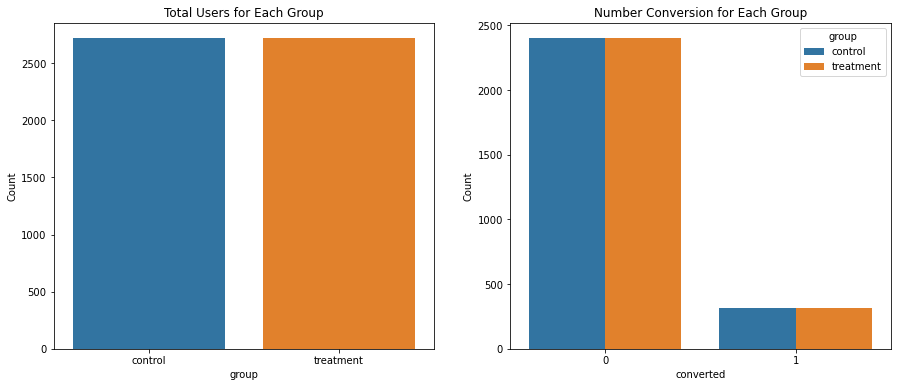

In [89]:
fig, axes = plt.subplots(1,2)

sns.countplot(x='group', data=ab_test, ax=axes[0])
axes[0].set(title="Total Users for Each Group", ylabel='Count')

sns.countplot(x='converted', data=ab_test, ax=axes[1], hue='group')
axes[1].set(title='Number Conversion for Each Group', ylabel='Count')
fig.set_size_inches(15, 6)

Based on the graph above, total users for each group in this experiment are balanced enough.

In [90]:
conversion_rates = ab_test.groupby('group')['converted'].agg([np.mean, np.std])
conversion_rates.columns = ['conversion_rate', 'std_deviation']
conversion_rates

,conversion_rate,std_deviation
group,,
control,0.117323,0.321863
treatment,0.116955,0.321425


In this project, we will be performing two-tailed hypothesis testing with confidence interval of 95% ***(alpha treshold = 0.05)***.

**The hypothesis will be formulated as follow :**

H0 : Conversion rate of old design is equal to conversion rate of new design

H1 : Conversion rate of old design is not equal to conversion rate of new design

In [91]:
from statsmodels.stats.weightstats import ztest 

z_score, p_value = ztest(control_group['converted'],treatment_group['converted'])
print('z-score = ',z_score)
print('p-value = ',p_value)

if p_value<0.05:
    print('\nP-value score ({}) is smaller than alpha threshold (0.05), we have enough evidence to reject null hypothesis.' .format(p_value.round(2)))
else:
    print('\nP-value score ({}) is bigger than alpha threshold (0.05), we don\'t have enough convidence to reject null hypothesis.' .format(p_value.round(2)))

z-score =  0.04216035177716724
p-value =  0.9663708691374466

P-value score (0.97) is bigger than alpha threshold (0.05), we don't have enough convidence to reject null hypothesis.


### **Result** 

We don't have enough convidence to reject null hypothesis, therefore we **accept null hypothesis**. 


### **Conclusion**

The conversion rate of old design **is equal** to conversion rate of new design. So, new version of menu page **doesn't give better** conversion rate.